# 01 - Experimentation

## Overview

### Scenario

The [Chicago Taxi Trips](https://pantheon.corp.google.com/marketplace/details/city-of-chicago-public-data/chicago-taxi-trips) dataset is one ofof [public datasets hosted with BigQuery](https://cloud.google.com/bigquery/public-data/), which includes taxi trips from 2013 to the present, reported to the City of Chicago in its role as a regulatory agency. The `taxi_trips` table size is 70.72 GB and includes more than 195 million records. The dataset includes information about the trips, like pickup and dropoff datetime and location, passengers count, miles travelled, and trip toll. 

The ML task is to predict whether a given trip will result in a tip > 20%.

### Lab flow 


1. Perform Exploratory Data Analysis and Visualization.
2. Prepare the data for the ML task in BigQuery.
3. Produce and fix the raw data schema.
4. Create a managed dataset.


## Setup

In [4]:
%load_ext autoreload
%autoreload 2?

In [32]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from google.cloud import bigquery
from google.cloud import aiplatform 
from google.cloud import exceptions

### Configure project and region

In [9]:
PROJECT = 'jk-mlops-dev' # Change to your project Id.
REGION = 'us-central1'

### Configure a GCS bucket

In [10]:
GCS_BUCKET = 'gs://jk-vertex-labs'

!gsutil mb -l $REGION $GCS_BUCKET

Creating gs://jk-vertex-labs/...


### Configure a BigQuery staging dataset

In [37]:
BQ_LOCATION = 'US' # Change to your location
BQ_DATASET_NAME = 'experimentation_dataset' # Change to your BQ datasent name.
BQ_TABLE_NAME = 'chicago_taxitrips_prep'

DATASET_DISPLAY_NAME = 'chicago_taxi_tips_v2'
BQ_URI = f"bq://{PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME}"

In [38]:
client = bigquery.Client(project=PROJECT)

dataset = None
try: 
    dataset_id = '{}.{}'.format(client.project, BQ_DATASET_NAME)
    dataset = bigquery.Dataset(dataset_id)
    dataset.location = BQ_LOCATION
    dataset = client.create_dataset(dataset, timeout=30)
except exceptions.Conflict:
    print('Dataset already exists')

Dataset already exists


## 1. Explore Chicago Taxi Dataset

In [46]:
%%bigquery data

SELECT *
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  7.75rows/s]


In [47]:
data

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,c0550371b8a815ecc4d70528c29385f4e5a7065d,45f37403538a1c4651bcaa58ab3c436b98f0bf7fbe060b...,2018-09-01 19:15:00+00:00,2018-09-01 19:30:00+00:00,660,1.00,NaN,NaN,NaN,NaN,...,0.0,7.50,Cash,Medallion Leasin,NaN,NaN,None,NaN,NaN,None
1,92f76eb6cfd20b862fefcdafffb4f98b13fb8be0,45f37403538a1c4651bcaa58ab3c436b98f0bf7fbe060b...,2018-09-01 19:30:00+00:00,2018-09-01 19:30:00+00:00,240,0.40,NaN,NaN,NaN,NaN,...,1.0,9.25,Credit Card,Medallion Leasin,NaN,NaN,None,NaN,NaN,None
2,e8ac60ddcabecf7b4a1865ef2781738a36f83d58,45f37403538a1c4651bcaa58ab3c436b98f0bf7fbe060b...,2018-09-01 19:30:00+00:00,2018-09-01 19:45:00+00:00,600,2.00,NaN,NaN,NaN,NaN,...,1.0,10.00,Cash,Medallion Leasin,NaN,NaN,None,NaN,NaN,None
3,ba4e3e55d62c3617dd15a2c49a28f3831c7560a0,bedb270bce40664555c0e645a3f6c242d8f64ed541f6f5...,2018-08-30 04:00:00+00:00,2018-08-30 04:30:00+00:00,1853,4.16,NaN,NaN,NaN,NaN,...,0.0,17.00,Prcard,Flash Cab,NaN,NaN,None,NaN,NaN,None
4,f4a044e9d2b2e02c5060d4d037ad924c4aa966b8,bedb270bce40664555c0e645a3f6c242d8f64ed541f6f5...,2018-08-30 05:15:00+00:00,2018-08-30 05:15:00+00:00,49,0.00,NaN,NaN,NaN,NaN,...,0.0,3.25,Cash,Flash Cab,NaN,NaN,None,NaN,NaN,None
5,30833c66640e4af1e4c0decefbb070aa9829024c,bedb270bce40664555c0e645a3f6c242d8f64ed541f6f5...,2018-08-30 05:15:00+00:00,2018-08-30 05:15:00+00:00,62,0.00,NaN,NaN,NaN,NaN,...,0.0,3.25,Cash,Flash Cab,NaN,NaN,None,NaN,NaN,None
6,4f859a67a47c809c43f8cd5ff5cb3e590c1d8f6b,bedb270bce40664555c0e645a3f6c242d8f64ed541f6f5...,2018-08-30 05:30:00+00:00,2018-08-30 05:30:00+00:00,48,0.00,NaN,NaN,NaN,NaN,...,0.0,3.25,Cash,Flash Cab,NaN,NaN,None,NaN,NaN,None
7,ab6afbe1a9398cbde10a600fe65a0a84a9dbd0d9,bedb270bce40664555c0e645a3f6c242d8f64ed541f6f5...,2018-08-30 05:30:00+00:00,2018-08-30 05:45:00+00:00,577,1.06,NaN,NaN,NaN,NaN,...,0.0,6.75,Prcard,Flash Cab,NaN,NaN,None,NaN,NaN,None
8,04923fd53b0642e80e661f1a8d11b56b29f401a8,bedb270bce40664555c0e645a3f6c242d8f64ed541f6f5...,2018-08-30 05:45:00+00:00,2018-08-30 06:00:00+00:00,229,0.49,NaN,NaN,NaN,NaN,...,1.0,8.00,Credit Card,Flash Cab,NaN,NaN,None,NaN,NaN,None
9,7409e996ee8a012b75f541c9218a77a0a520726e,bedb270bce40664555c0e645a3f6c242d8f64ed541f6f5...,2018-08-30 06:30:00+00:00,2018-08-30 06:45:00+00:00,890,1.65,NaN,NaN,NaN,NaN,...,1.0,9.75,Cash,Flash Cab,NaN,NaN,None,NaN,NaN,None


In [74]:
%%bigquery 

SELECT FORMAT_TIMESTAMP("%m-%d-%Y", trip_start_timestamp)
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  6.81rows/s]


,f0_
0,06-23-2017
1,06-23-2017
2,06-23-2017
3,06-23-2017
4,06-23-2017
5,06-23-2017
6,06-21-2017
7,06-21-2017
8,06-21-2017
9,06-21-2017


In [50]:
%%bigquery data

SELECT 
    CAST(EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS string) AS trip_dayofweek, 
    FORMAT_DATE('%A',cast(trip_start_timestamp as date)) AS trip_dayname,
    COUNT(*) as trip_count,
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
    EXTRACT(YEAR FROM trip_start_timestamp) = 2015 
GROUP BY
    trip_dayofweek,
    trip_dayname
ORDER BY
    trip_dayofweek
;

Downloading: 100%|██████████| 7/7 [00:01<00:00,  4.94rows/s]


<AxesSubplot:xlabel='trip_dayname'>

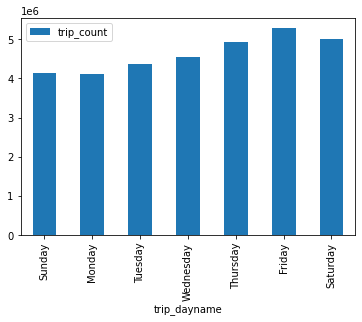

In [51]:
data.plot(kind='bar', x='trip_dayname', y='trip_count')

## 2. Create data for the ML task

We add `data_split` column, where 80% of the records is set to `UNASSIGNED` while the other 20% is set to `TEST`.
This column will the custom model (or an AutoML Tables model) to split the data for learning and testing.
In the learning phase, each model will split the `UNASSIGNED` records to `train` and `eval`. The `TEST` split is will be used for the final model validation.

In [54]:
sample_size = 1000000
year = 2020

In [75]:
sql_script = '''
CREATE OR REPLACE TABLE `@PROJECT.@DATASET.@TABLE` 
AS (
    WITH
      taxitrips AS (
      SELECT
        trip_start_timestamp,
        trip_seconds,
        trip_miles,
        payment_type,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude,
        tips,
        fare,
        FORMAT_TIMESTAMP("%m-%d-%Y", trip_start_timestamp) as trip_date
      FROM
        `bigquery-public-data.chicago_taxi_trips.taxi_trips`
      WHERE 1=1 
      AND pickup_longitude IS NOT NULL
      AND pickup_latitude IS NOT NULL
      AND dropoff_longitude IS NOT NULL
      AND dropoff_latitude IS NOT NULL
      AND trip_miles > 0
      AND trip_seconds > 0
      AND fare > 0
      AND EXTRACT(YEAR FROM trip_start_timestamp) = @YEAR
    )

    SELECT
      trip_start_timestamp,   
      EXTRACT(MONTH from trip_start_timestamp) as trip_month,
      EXTRACT(DAY from trip_start_timestamp) as trip_day,
      EXTRACT(DAYOFWEEK from trip_start_timestamp) as trip_day_of_week,
      EXTRACT(HOUR from trip_start_timestamp) as trip_hour,
      trip_seconds,
      trip_miles,
      payment_type,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(pickup_longitude, pickup_latitude), 0.1)
      ) AS pickup_grid,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(dropoff_longitude, dropoff_latitude), 0.1)
      ) AS dropoff_grid,
      ST_Distance(
          ST_GeogPoint(pickup_longitude, pickup_latitude), 
          ST_GeogPoint(dropoff_longitude, dropoff_latitude)
      ) AS euclidean,
      CONCAT(
          ST_AsText(ST_SnapToGrid(ST_GeogPoint(pickup_longitude,
              pickup_latitude), 0.1)), 
          ST_AsText(ST_SnapToGrid(ST_GeogPoint(dropoff_longitude,
              dropoff_latitude), 0.1))
      ) AS loc_cross,
      IF((tips/fare >= 0.2), 1, 0) AS tip_bin,
      IF(ABS(MOD(FARM_FINGERPRINT(trip_date), 10)) < 8, 'UNASSIGNED', 'TEST') AS data_split
    FROM
      taxitrips
    LIMIT @LIMIT
)
'''

In [76]:
sql_script = sql_script.replace(
    '@PROJECT', PROJECT).replace(
    '@DATASET', BQ_DATASET_NAME).replace(
    '@TABLE', BQ_TABLE_NAME).replace(
    '@YEAR', str(year)).replace(
    '@LIMIT', str(sample_size))

In [77]:
print(sql_script)


CREATE OR REPLACE TABLE `jk-mlops-dev.experimentation_dataset.chicago_taxitrips_prep` 
AS (
    WITH
      taxitrips AS (
      SELECT
        trip_start_timestamp,
        trip_seconds,
        trip_miles,
        payment_type,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude,
        tips,
        fare,
        FORMAT_TIMESTAMP("%m-%d-%Y", trip_start_timestamp) as trip_date
      FROM
        `bigquery-public-data.chicago_taxi_trips.taxi_trips`
      WHERE 1=1 
      AND pickup_longitude IS NOT NULL
      AND pickup_latitude IS NOT NULL
      AND dropoff_longitude IS NOT NULL
      AND dropoff_latitude IS NOT NULL
      AND trip_miles > 0
      AND trip_seconds > 0
      AND fare > 0
      AND EXTRACT(YEAR FROM trip_start_timestamp) = 2020
    )

    SELECT
      trip_start_timestamp,   
      EXTRACT(MONTH from trip_start_timestamp) as trip_month,
      EXTRACT(DAY from trip_start_timestamp) as trip_day,
      EXTRACT(DAYOFWEEK 

In [78]:
job = client.query(sql_script)
job.result()

In [ ]:
BQ_DATASET_NAME = 'experimentation_dataset' # Change to your BQ datasent name.
BQ_TABLE_NAME = 'chicago_taxitrips_prep'

In [83]:
sql_script = f'''
SELECT * EXCEPT (trip_start_timestamp, data_split)
FROM {PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME}
'''

sample_data = client.query(sql_script).to_dataframe()

In [84]:
sample_data.head().T

,0,1,2,3,4
trip_month,6,6,6,6,6
trip_day,19,19,19,19,19
trip_day_of_week,6,6,6,6,6
trip_hour,0,0,0,0,0
trip_seconds,660,1780,240,1200,619
trip_miles,1.1,9.64,0.9,4.1,0.78
payment_type,Cash,Prcard,Cash,Cash,Cash
pickup_grid,POINT(-87.7 41.9),POINT(-87.7 41.8),POINT(-87.7 42),POINT(-87.6 41.8),POINT(-87.7 42)
dropoff_grid,POINT(-87.6 41.9),POINT(-87.6 41.7),POINT(-87.7 42),POINT(-87.7 41.9),POINT(-87.7 42)
euclidean,3788.78383,12414.729032,2406.040979,2210.049904,3000.241665


In [85]:
sample_data.tip_bin.value_counts()

0    635470
1    364530
Name: tip_bin, dtype: int64

<AxesSubplot:>

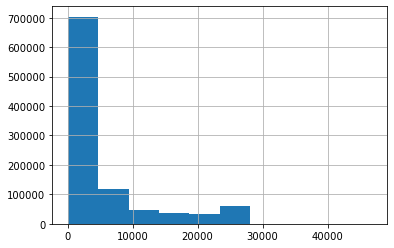

In [86]:
sample_data.euclidean.hist()

## 3. Generate Raw Data Schema

The raw data schema will be used in:
1. Defining the input columns for the AutoML Tables model.
2. Indentifying the raw data types and shapes in the data transformation.
3. Create the serving input signature for the custom model.
4. Validating the new raw training data in the tfx pipeline.

In [ ]:
stats = tfdv.generate_statistics_from_dataframe(
    dataframe=sample_data,
    stats_options=tfdv.StatsOptions(
        label_feature='tip_bin',
        weight_feature=None,
        sample_rate=1,
        num_top_values=50
    )
)

In [ ]:
tfdv.visualize_statistics(stats)

In [ ]:
schema = tfdv.infer_schema(statistics=stats)
tfdv.display_schema(schema=schema)

In [ ]:
raw_schema_location = os.path.join(RAW_SCHEMA_DIR, 'schema.pbtxt')
tfdv.write_schema_text(schema, raw_schema_location)

## 4. Create Managed AI Platform Dataset

In [ ]:
from src.utils.vertex_utils import VertexClient
vertex_client = VertexClient(PROJECT, REGION)

### Create managed dataset

In [ ]:
dataset = vertex_client.create_dataset_bq(DATASET_DISPLAY_NAME, BQ_URI)
dataset.gca_resource

### List datasets

In [ ]:
dataset = vertex_client.get_dataset_by_display_name(DATASET_DISPLAY_NAME)
dataset.resource_name 

In [ ]:
dataset.gca_resource.metadata['inputConfig']['bigquerySource']['uri']